# 04 - Análisis Comparativo y Consolidado

**Proyecto:** EDA de Dengue en Colombia  
**Maestría en Inteligencia Artificial** - Desarrollo de Soluciones  

Este notebook presenta el análisis comparativo entre dengue regular y grave, y la correlación con variables climáticas.

**Contenido:**
1. Comparación dengue regular vs grave por año
2. Proporción dengue grave / total
3. Tendencias temporales
4. Mapas de calor por departamento
5. Correlación con variables climáticas
6. Estacionalidad y picos epidémicos
7. Conclusiones y hallazgos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, os.path.join('..', 'src'))
from utils import (
    cargar_dengue, cargar_dane, cargar_clima, configurar_estilo,
    convertir_edad_anos, clasificar_grupo_etario, resumen_dataframe,
    COLORES_ANOS, PALETA_DENGUE, ANOS_ESTUDIO
)

configurar_estilo()
pd.set_option('display.max_columns', 50)

In [2]:
# Cargar todos los datos
print('Cargando datos...')
print('\n--- Dengue Regular (210) ---')
df_reg = cargar_dengue(tipo='regular')
df_reg['edad_anos'] = convertir_edad_anos(df_reg)
df_reg['grupo_etario'] = clasificar_grupo_etario(df_reg['edad_anos'])
df_reg = df_reg.drop_duplicates(subset=['CONSECUTIVE'], keep='first')
df_reg['tipo_dengue'] = 'Regular'

print('\n--- Dengue Grave (220) ---')
df_grav = cargar_dengue(tipo='grave')
df_grav['edad_anos'] = convertir_edad_anos(df_grav)
df_grav['grupo_etario'] = clasificar_grupo_etario(df_grav['edad_anos'])
df_grav = df_grav.drop_duplicates(subset=['CONSECUTIVE'], keep='first')
df_grav['tipo_dengue'] = 'Grave'

print('\n--- DANE ---')
df_dane = cargar_dane()

print('\n--- Datos Climáticos ---')
df_clima = cargar_clima()

print(f'\nDengue Regular: {len(df_reg):,} registros')
print(f'Dengue Grave: {len(df_grav):,} registros')

Cargando datos...

--- Dengue Regular (210) ---
  Cargando Datos_2010_210.xlsx... 147,224 registros, 72 columnas
  Cargando Datos_2016_210.xlsx... 100,117 registros, 72 columnas
  Cargando Datos_2022_210.xlsx... 65,691 registros, 72 columnas
  Cargando Datos_2024_210.xlsx... 309,627 registros, 72 columnas

  Total: 622,659 registros

--- Dengue Grave (220) ---
  Cargando Datos_2010_220.xls... 9,753 registros, 72 columnas
  Cargando Datos_2016_220.xls... 899 registros, 72 columnas
  Cargando Datos_2019_220.xls... 1,348 registros, 72 columnas
  Cargando Datos_2022_220.xls... 1,340 registros, 72 columnas
  Cargando Datos_2024_220.xlsx... 3,016 registros, 72 columnas

  Total: 16,356 registros

--- DANE ---

--- Datos Climáticos ---

Dengue Regular: 622,659 registros
Dengue Grave: 16,356 registros


## 1. Comparación Dengue Regular vs Grave por Año

In [3]:
# Conteo por año y tipo
conteo_reg = df_reg['ANO'].value_counts().sort_index().rename('Regular')
conteo_grav = df_grav['ANO'].value_counts().sort_index().rename('Grave')

df_conteo = pd.DataFrame({'Regular': conteo_reg, 'Grave': conteo_grav}).fillna(0).astype(int)
df_conteo['Total'] = df_conteo['Regular'] + df_conteo['Grave']
df_conteo['Proporción Grave (%)'] = (df_conteo['Grave'] / df_conteo['Total'] * 100).round(2)

print('Casos por año y tipo de dengue:')
print(df_conteo.to_string())

Casos por año y tipo de dengue:
      Regular  Grave   Total  Proporción Grave (%)
ANO                                               
2010   147224   9753  156977                  6.21
2016   100117    899  101016                  0.89
2019        0   1348    1348                100.00
2022    65691   1340   67031                  2.00
2024   309627   3016  312643                  0.96


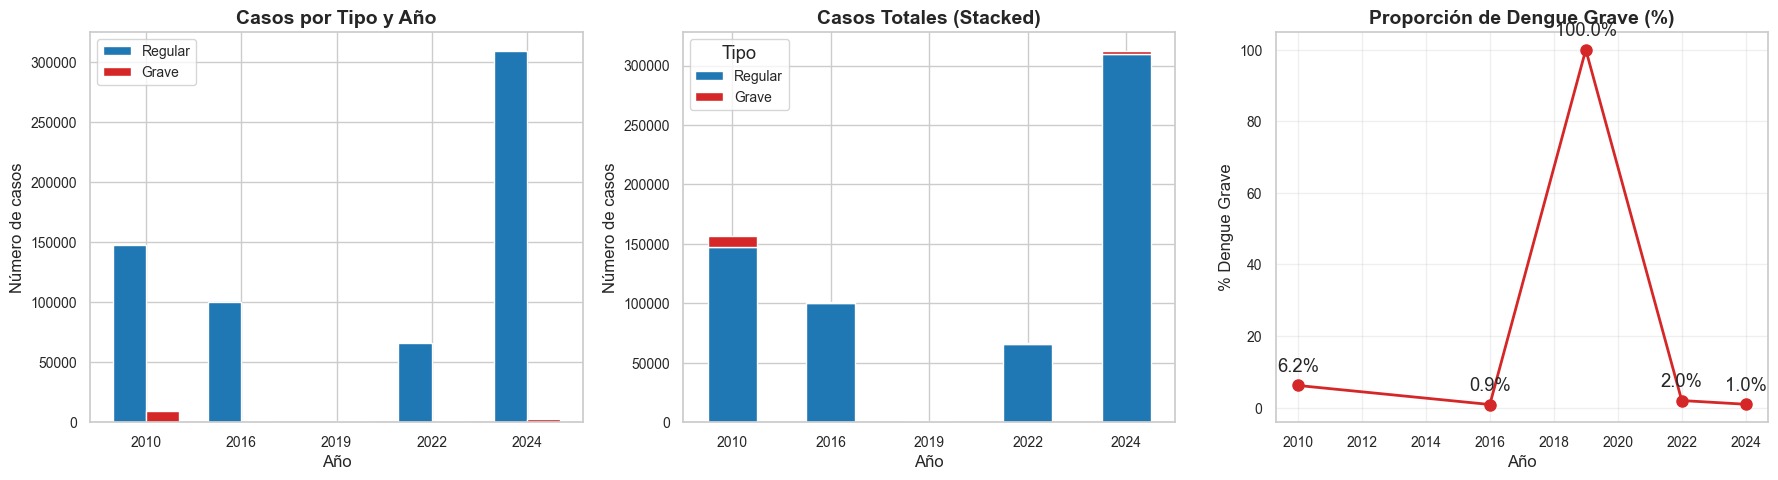

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Barras agrupadas
x = np.arange(len(df_conteo.index))
width = 0.35
axes[0].bar(x - width/2, df_conteo['Regular'], width, label='Regular',
            color=PALETA_DENGUE['regular'], edgecolor='white')
axes[0].bar(x + width/2, df_conteo['Grave'], width, label='Grave',
            color=PALETA_DENGUE['grave'], edgecolor='white')
axes[0].set_xticks(x)
axes[0].set_xticklabels(df_conteo.index.astype(int))
axes[0].set_title('Casos por Tipo y Año', fontweight='bold')
axes[0].set_ylabel('Número de casos')
axes[0].legend()
axes[0].set_xlabel('Año')

# Total con stacked bars
df_conteo[['Regular', 'Grave']].plot(kind='bar', stacked=True, ax=axes[1],
    color=[PALETA_DENGUE['regular'], PALETA_DENGUE['grave']], edgecolor='white')
axes[1].set_title('Casos Totales (Stacked)', fontweight='bold')
axes[1].set_ylabel('Número de casos')
axes[1].set_xlabel('Año')
axes[1].tick_params(axis='x', rotation=0)
axes[1].legend(title='Tipo')

# Proporción dengue grave
axes[2].plot(df_conteo.index.astype(int), df_conteo['Proporción Grave (%)'],
             marker='o', color=PALETA_DENGUE['grave'], linewidth=2, markersize=8)
axes[2].set_title('Proporción de Dengue Grave (%)', fontweight='bold')
axes[2].set_ylabel('% Dengue Grave')
axes[2].set_xlabel('Año')
axes[2].grid(True, alpha=0.3)
for i, row in df_conteo.iterrows():
    axes[2].annotate(f'{row["Proporción Grave (%)"]:.1f}%',
                     (int(i), row['Proporción Grave (%)']),
                     textcoords='offset points', xytext=(0, 10), ha='center')

plt.tight_layout()
plt.show()

## 2. Tendencias Temporales - Curvas Epidémicas Comparadas

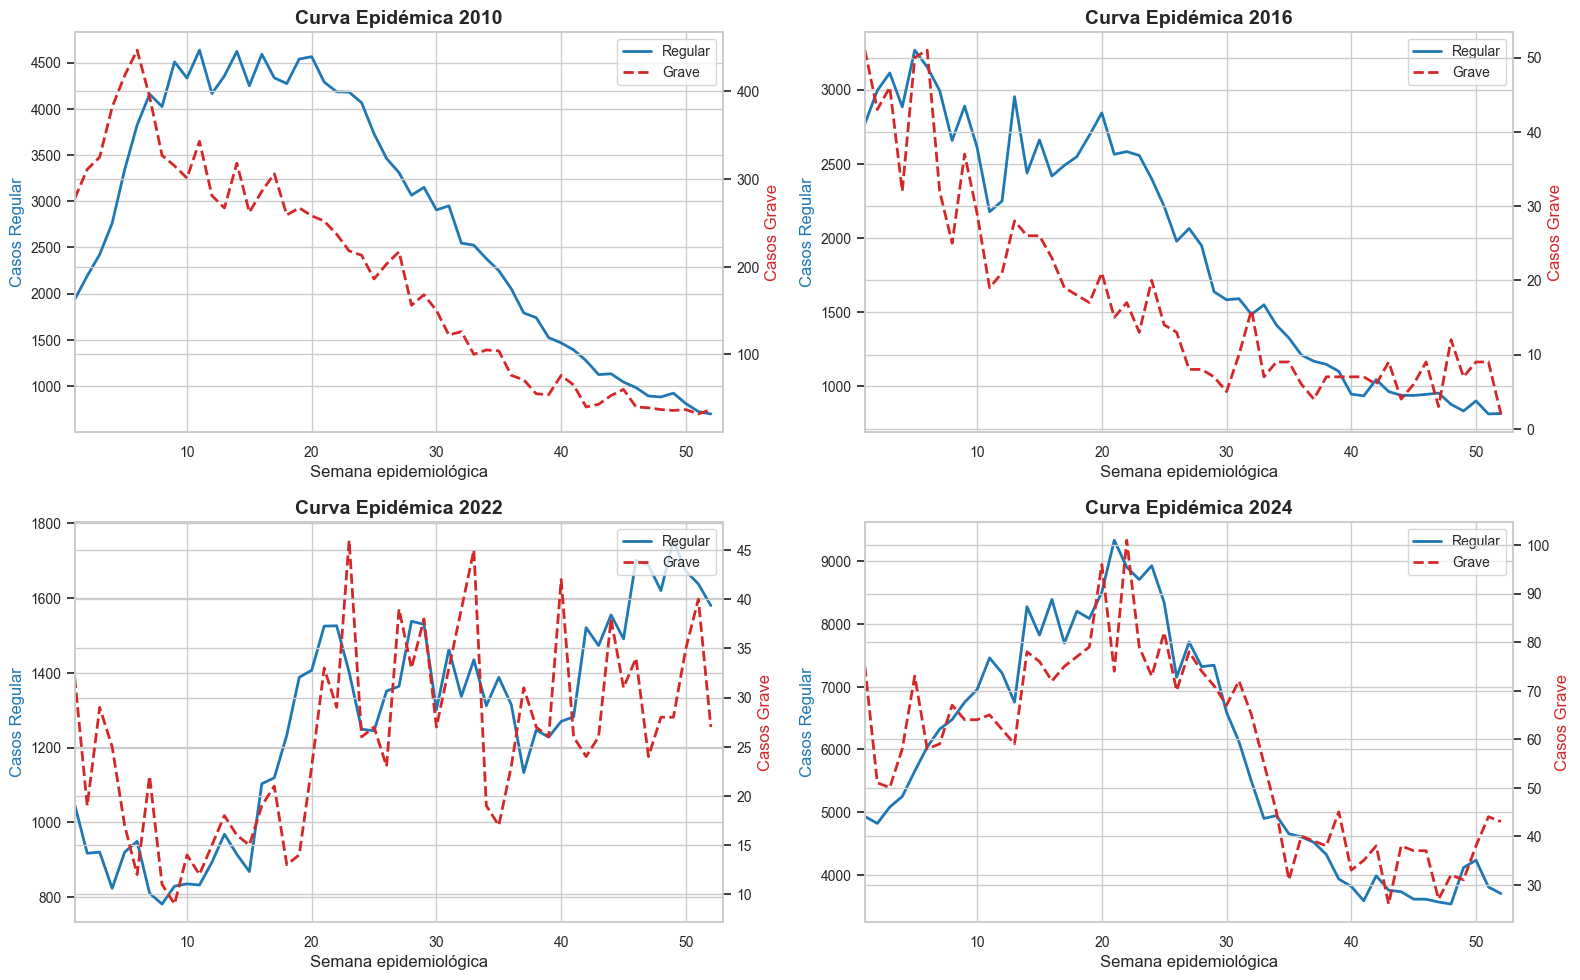

In [5]:
# Curvas epidémicas superpuestas - Regular vs Grave
# Solo para años que tienen ambos tipos (excluir 2019 que solo tiene grave)
anos_comunes = sorted(set(df_reg['ANO'].unique()) & set(df_grav['ANO'].unique()))

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for idx, ano in enumerate(anos_comunes):
    ax = axes[idx // 2, idx % 2]
    
    # Regular
    reg_ano = df_reg[df_reg['ANO'] == ano]['SEMANA'].value_counts().sort_index()
    ax.plot(reg_ano.index, reg_ano.values, label='Regular',
            color=PALETA_DENGUE['regular'], linewidth=2)
    
    # Grave (escala derecha)
    ax2 = ax.twinx()
    grav_ano = df_grav[df_grav['ANO'] == ano]['SEMANA'].value_counts().sort_index()
    ax2.plot(grav_ano.index, grav_ano.values, label='Grave',
             color=PALETA_DENGUE['grave'], linewidth=2, linestyle='--')
    
    ax.set_title(f'Curva Epidémica {ano}', fontweight='bold')
    ax.set_xlabel('Semana epidemiológica')
    ax.set_ylabel('Casos Regular', color=PALETA_DENGUE['regular'])
    ax2.set_ylabel('Casos Grave', color=PALETA_DENGUE['grave'])
    ax.set_xlim(1, 53)
    
    # Leyenda combinada
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()

## 3. Comparación Geográfica

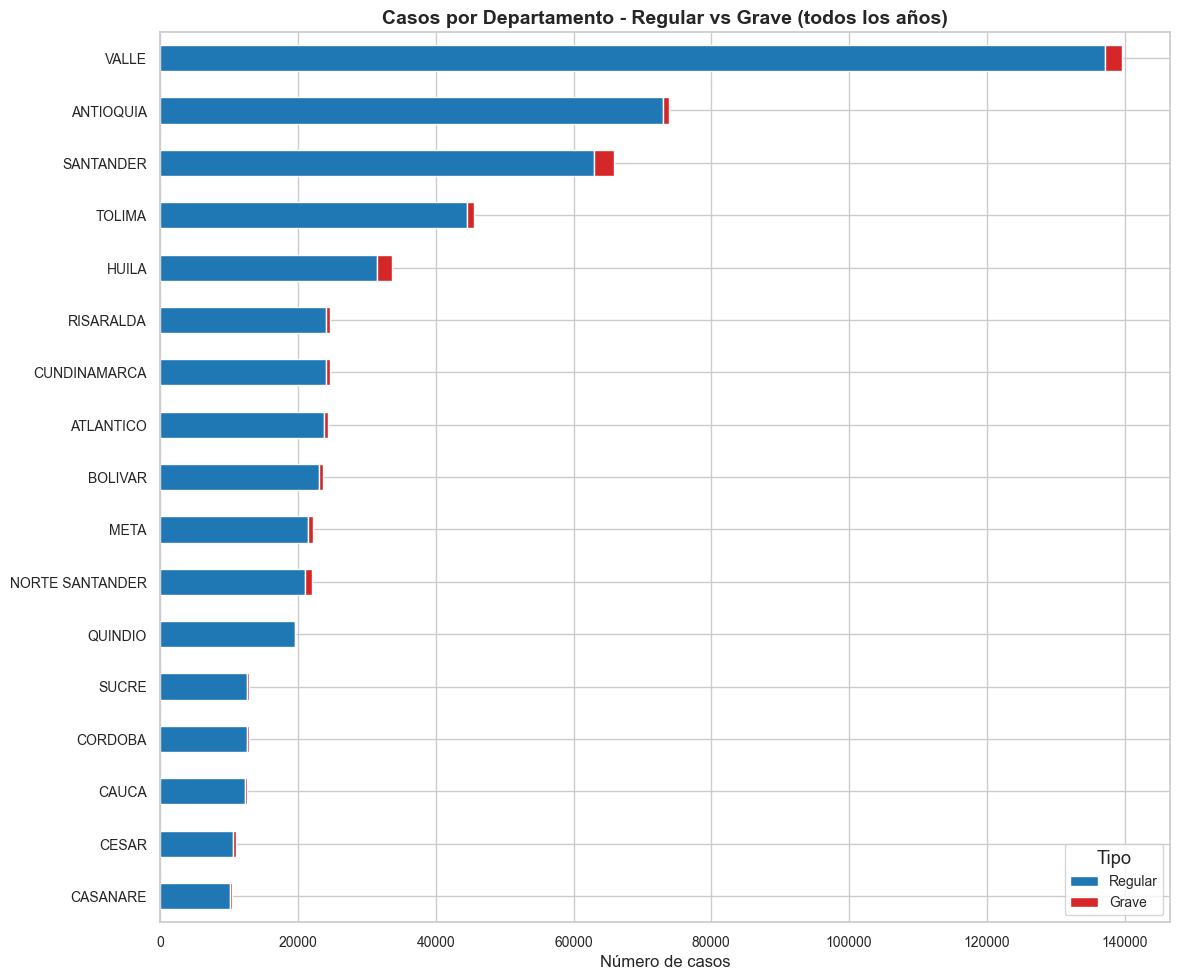

In [6]:
# Top departamentos - comparación regular vs grave
top_dptos_reg = df_reg['Departamento_ocurrencia'].value_counts().head(15)
top_dptos_grav = df_grav['Departamento_ocurrencia'].value_counts().head(15)

# Combinar para los top 15 de cualquiera
dptos_union = list(set(top_dptos_reg.index) | set(top_dptos_grav.index))

df_comp_dpto = pd.DataFrame({
    'Regular': df_reg[df_reg['Departamento_ocurrencia'].isin(dptos_union)]
               ['Departamento_ocurrencia'].value_counts(),
    'Grave': df_grav[df_grav['Departamento_ocurrencia'].isin(dptos_union)]
             ['Departamento_ocurrencia'].value_counts(),
}).fillna(0).astype(int)
df_comp_dpto['Total'] = df_comp_dpto['Regular'] + df_comp_dpto['Grave']
df_comp_dpto = df_comp_dpto.sort_values('Total', ascending=True)

fig, ax = plt.subplots(figsize=(12, 10))
df_comp_dpto[['Regular', 'Grave']].plot(kind='barh', stacked=True, ax=ax,
    color=[PALETA_DENGUE['regular'], PALETA_DENGUE['grave']], edgecolor='white')
ax.set_title('Casos por Departamento - Regular vs Grave (todos los años)',
             fontweight='bold')
ax.set_xlabel('Número de casos')
ax.set_ylabel('')
ax.legend(title='Tipo')
plt.tight_layout()
plt.show()

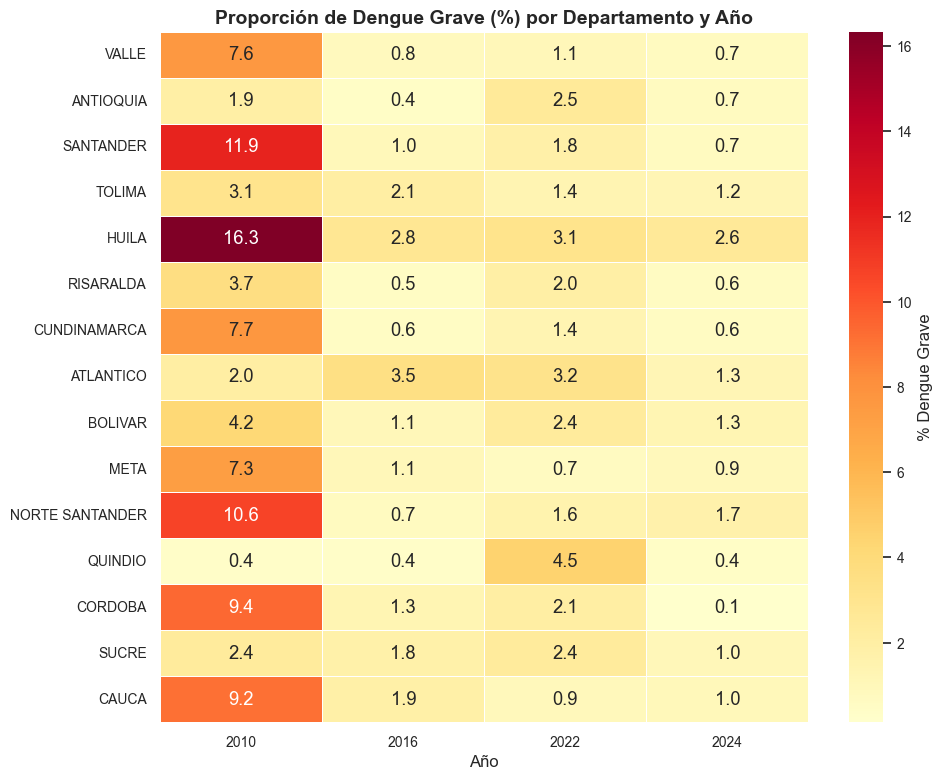

In [7]:
# Heatmap: Proporción de dengue grave por departamento y año
top15_dptos = (df_reg['Departamento_ocurrencia'].value_counts().head(15).index.tolist())

prop_grave = []
for dpto in top15_dptos:
    for ano in anos_comunes:
        n_reg = len(df_reg[(df_reg['Departamento_ocurrencia'] == dpto) & (df_reg['ANO'] == ano)])
        n_grav = len(df_grav[(df_grav['Departamento_ocurrencia'] == dpto) & (df_grav['ANO'] == ano)])
        total = n_reg + n_grav
        pct = (n_grav / total * 100) if total > 0 else 0
        prop_grave.append({'departamento': dpto, 'ano': ano, 'pct_grave': pct, 'total': total})

df_prop = pd.DataFrame(prop_grave)
tabla_prop = df_prop.pivot(index='departamento', columns='ano', values='pct_grave')
tabla_prop = tabla_prop.loc[top15_dptos]  # Mantener orden

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(tabla_prop, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax,
            linewidths=0.5, cbar_kws={'label': '% Dengue Grave'})
ax.set_title('Proporción de Dengue Grave (%) por Departamento y Año', fontweight='bold')
ax.set_ylabel('')
ax.set_xlabel('Año')
plt.tight_layout()
plt.show()

## 4. Comparación Demográfica

ValueError: 2

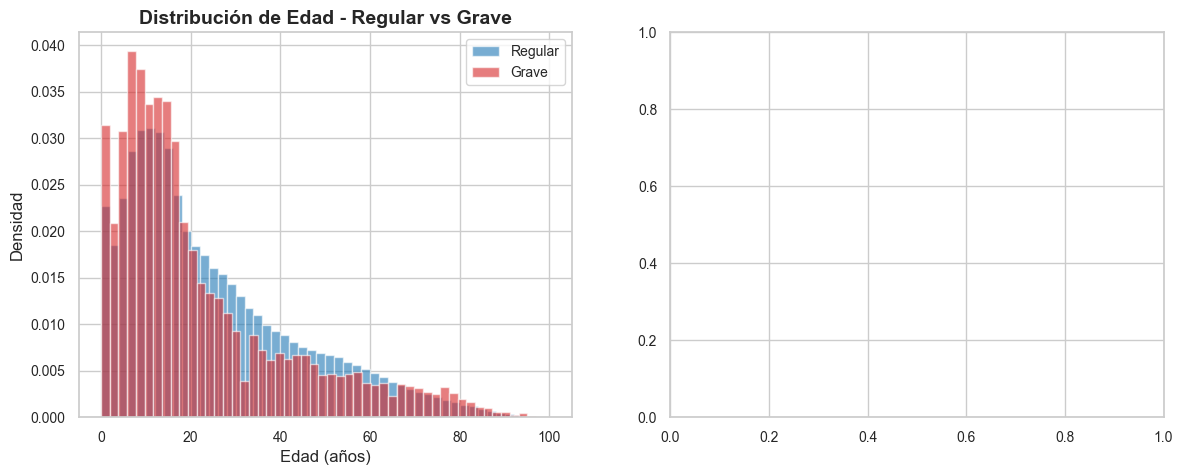

In [8]:
# Distribución de edad: Regular vs Grave
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma superpuesto
axes[0].hist(df_reg['edad_anos'].dropna().clip(0, 100), bins=50, alpha=0.6,
             color=PALETA_DENGUE['regular'], label='Regular', density=True, edgecolor='white')
axes[0].hist(df_grav['edad_anos'].dropna().clip(0, 100), bins=50, alpha=0.6,
             color=PALETA_DENGUE['grave'], label='Grave', density=True, edgecolor='white')
axes[0].set_title('Distribución de Edad - Regular vs Grave', fontweight='bold')
axes[0].set_xlabel('Edad (años)')
axes[0].set_ylabel('Densidad')
axes[0].legend()

# Boxplot comparativo
cols_comunes = list(set(df_reg.columns) & set(df_grav.columns))
df_ambos = pd.concat([
    df_reg[cols_comunes + ['tipo_dengue']],
    df_grav[cols_comunes + ['tipo_dengue']]
], ignore_index=True)

sns.boxplot(data=df_ambos, x='ANO', y='edad_anos', hue='tipo_dengue',
            palette=PALETA_DENGUE, ax=axes[1])
axes[1].set_title('Distribución de Edad por Año y Tipo', fontweight='bold')
axes[1].set_xlabel('Año')
axes[1].set_ylabel('Edad (años)')
axes[1].legend(title='Tipo')

plt.tight_layout()
plt.show()

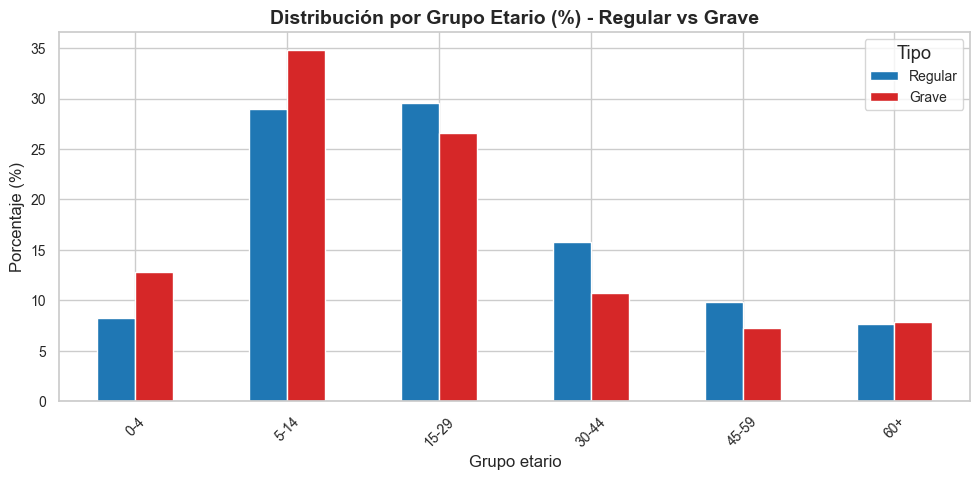

Distribución por grupo etario (%):
              Regular  Grave
grupo_etario                
0-4               8.3   12.8
5-14             29.0   34.9
15-29            29.5   26.6
30-44            15.8   10.7
45-59             9.8    7.3
60+               7.7    7.8


In [9]:
# Comparación de grupos etarios
ge_reg = df_reg['grupo_etario'].value_counts(normalize=True).sort_index() * 100
ge_grav = df_grav['grupo_etario'].value_counts(normalize=True).sort_index() * 100

df_ge = pd.DataFrame({'Regular': ge_reg, 'Grave': ge_grav}).fillna(0)

fig, ax = plt.subplots(figsize=(10, 5))
df_ge.plot(kind='bar', ax=ax, color=[PALETA_DENGUE['regular'], PALETA_DENGUE['grave']],
           edgecolor='white')
ax.set_title('Distribución por Grupo Etario (%) - Regular vs Grave', fontweight='bold')
ax.set_ylabel('Porcentaje (%)')
ax.set_xlabel('Grupo etario')
ax.tick_params(axis='x', rotation=45)
ax.legend(title='Tipo')
plt.tight_layout()
plt.show()

print('Distribución por grupo etario (%):')
print(df_ge.round(1).to_string())

## 5. Correlación con Variables Climáticas

Analizamos la relación entre las variables climáticas (temperatura, precipitación, NDVI, humedad) y los casos de dengue.

**Nota:** Esta sección requiere que se hayan descargado los datos climáticos con el notebook 00.

In [10]:
if df_clima is not None:
    print(f'Datos climáticos cargados: {len(df_clima):,} registros')
    print(f'Departamentos: {df_clima["departamento"].nunique()}')
    print(f'Años: {sorted(df_clima["ano"].unique())}')
    print(f'\nResumen:')
    print(df_clima.describe().round(2))
else:
    print('Datos climáticos no disponibles.')
    print('Ejecute primero el notebook 00_descarga_clima_gee.ipynb.')

Datos climáticos cargados: 1,980 registros
Departamentos: 33
Años: [np.int64(2010), np.int64(2016), np.int64(2019), np.int64(2022), np.int64(2024)]

Resumen:
           ano      mes  temperatura_c  precipitacion_mm     ndvi  dewpoint_c
count  1980.00  1980.00        1980.00           1920.00  1980.00     1860.00
mean   2018.20     6.50          27.14            222.53     0.63       19.51
std       4.92     3.45           3.64            133.21     0.11        3.81
min    2010.00     1.00          17.98              0.65     0.10        9.73
25%    2016.00     3.75          24.46            125.02     0.56       16.30
50%    2019.00     6.50          27.04            218.17     0.63       20.94
75%    2022.00     9.25          29.27            304.19     0.70       22.75
max    2024.00    12.00          39.61            973.79     0.86       25.53


Registros después del merge clima + dengue regular: 1,319


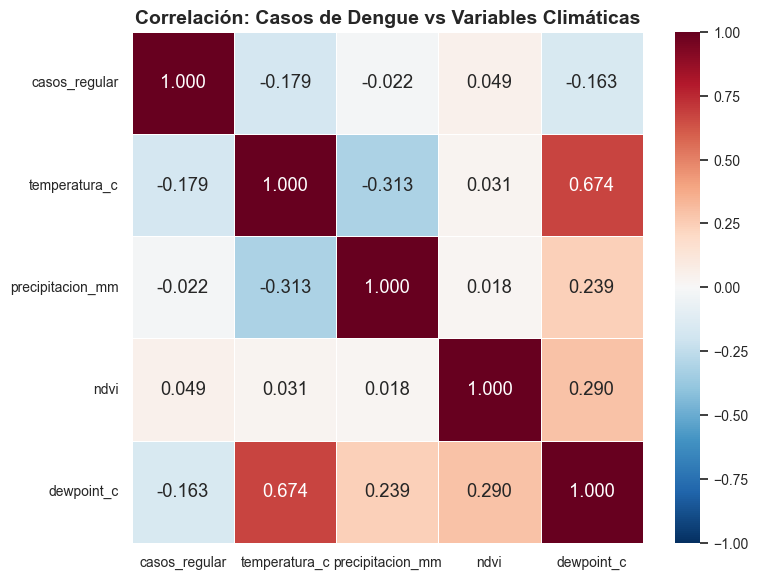

In [11]:
if df_clima is not None:
    # Agregar casos de dengue por departamento y mes para correlación
    df_reg['mes'] = pd.to_datetime(df_reg['FEC_NOT'], errors='coerce').dt.month
    df_grav['mes'] = pd.to_datetime(df_grav['FEC_NOT'], errors='coerce').dt.month
    
    # Casos regulares por depto, año, mes
    casos_reg_mensual = (df_reg.groupby(['Departamento_ocurrencia', 'ANO', 'mes'])
                         .size().reset_index(name='casos_regular'))
    
    # Casos graves por depto, año, mes
    casos_grav_mensual = (df_grav.groupby(['Departamento_ocurrencia', 'ANO', 'mes'])
                          .size().reset_index(name='casos_grave'))
    
    # Estandarizar nombres para join con clima
    # Los nombres de GEE pueden diferir de los del SIVIGILA
    # Intentamos un merge por nombre de departamento
    df_clima_upper = df_clima.copy()
    df_clima_upper['dpto_upper'] = df_clima_upper['departamento'].str.upper().str.strip()
    
    casos_reg_mensual['dpto_upper'] = casos_reg_mensual['Departamento_ocurrencia'].str.upper().str.strip()
    
    # Merge
    df_merged = casos_reg_mensual.merge(
        df_clima_upper,
        left_on=['dpto_upper', 'ANO', 'mes'],
        right_on=['dpto_upper', 'ano', 'mes'],
        how='inner'
    )
    
    print(f'Registros después del merge clima + dengue regular: {len(df_merged):,}')
    
    if len(df_merged) > 0:
        # Matriz de correlación
        vars_corr = ['casos_regular', 'temperatura_c', 'precipitacion_mm', 'ndvi', 'dewpoint_c']
        corr = df_merged[vars_corr].corr()
        
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.heatmap(corr, annot=True, fmt='.3f', cmap='RdBu_r', center=0, ax=ax,
                    linewidths=0.5, vmin=-1, vmax=1)
        ax.set_title('Correlación: Casos de Dengue vs Variables Climáticas', fontweight='bold')
        plt.tight_layout()
        plt.show()
else:
    print('Sección omitida: datos climáticos no disponibles.')

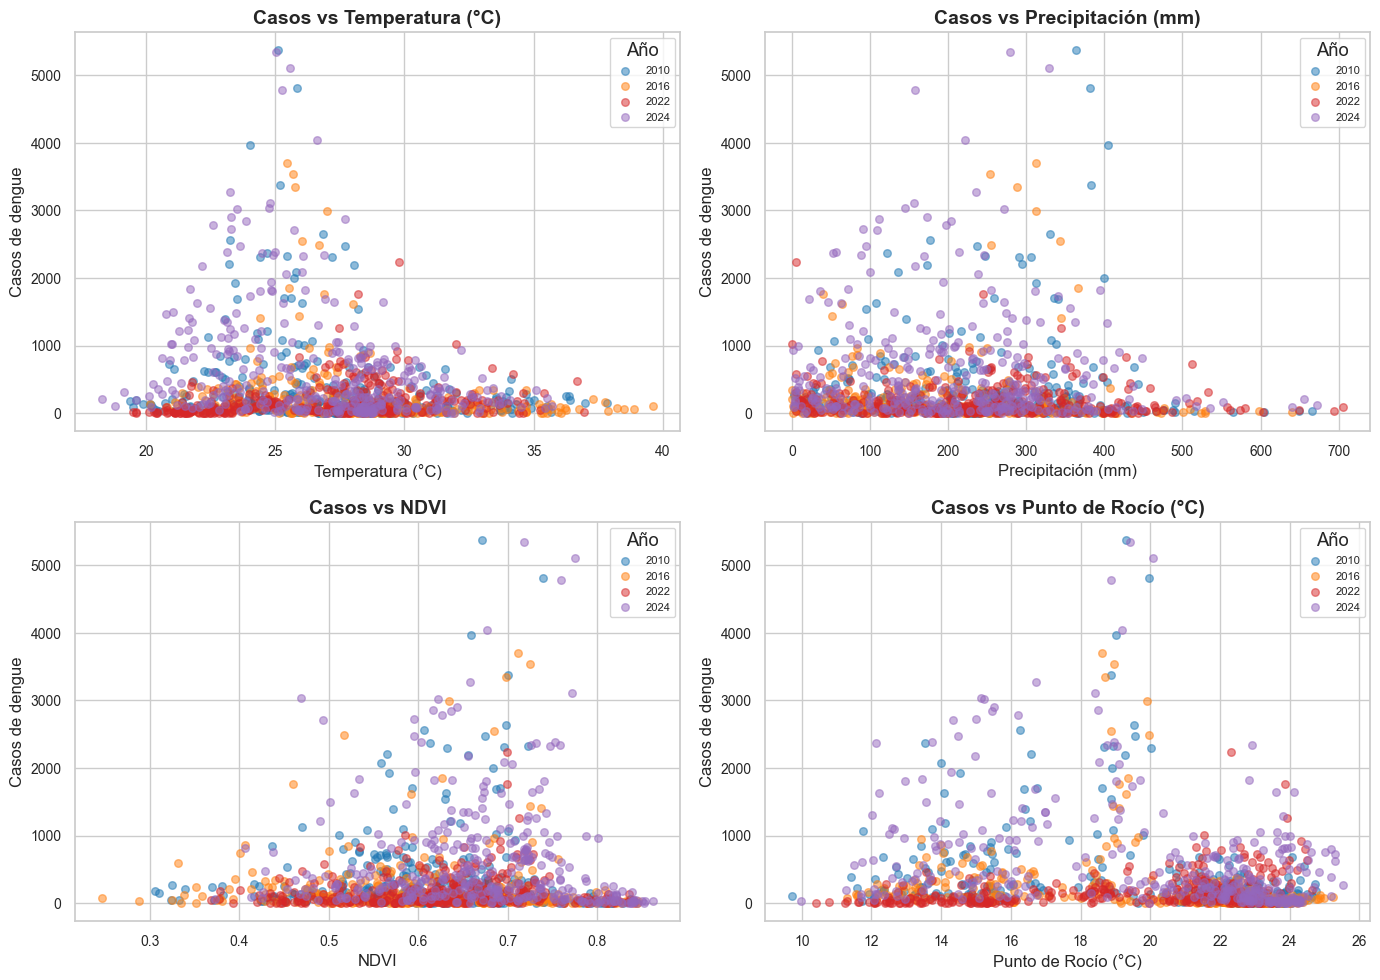

In [12]:
if df_clima is not None and len(df_merged) > 0:
    # Scatter plots: casos vs cada variable climática
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    variables = [
        ('temperatura_c', 'Temperatura (°C)', axes[0, 0]),
        ('precipitacion_mm', 'Precipitación (mm)', axes[0, 1]),
        ('ndvi', 'NDVI', axes[1, 0]),
        ('dewpoint_c', 'Punto de Rocío (°C)', axes[1, 1]),
    ]
    
    for var, titulo, ax in variables:
        for ano in sorted(df_merged['ANO'].unique()):
            datos_ano = df_merged[df_merged['ANO'] == ano]
            ax.scatter(datos_ano[var], datos_ano['casos_regular'], 
                      alpha=0.5, s=30, label=str(ano),
                      color=COLORES_ANOS.get(ano, '#333'))
        ax.set_xlabel(titulo)
        ax.set_ylabel('Casos de dengue')
        ax.set_title(f'Casos vs {titulo}', fontweight='bold')
        ax.legend(fontsize=8, title='Año')
    
    plt.tight_layout()
    plt.show()
else:
    print('Sección omitida: datos climáticos no disponibles.')

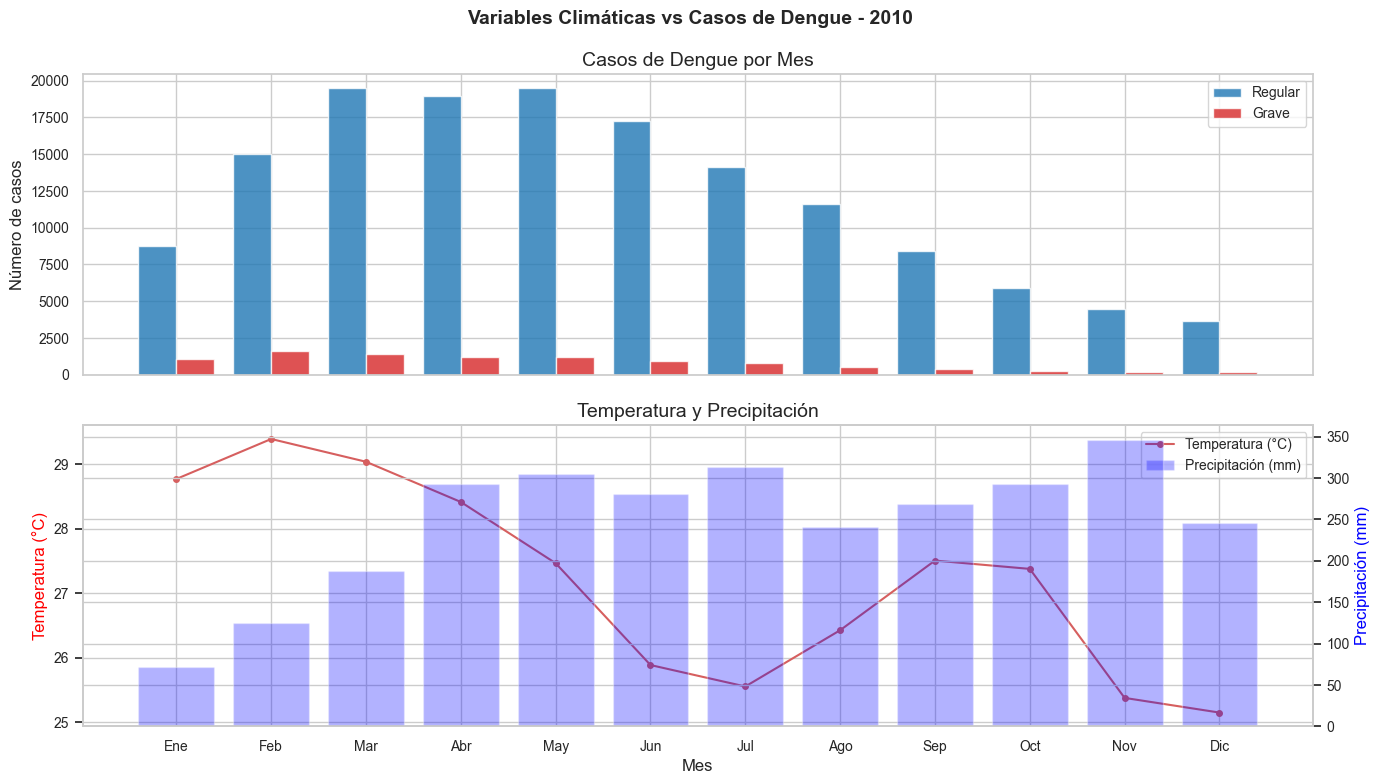

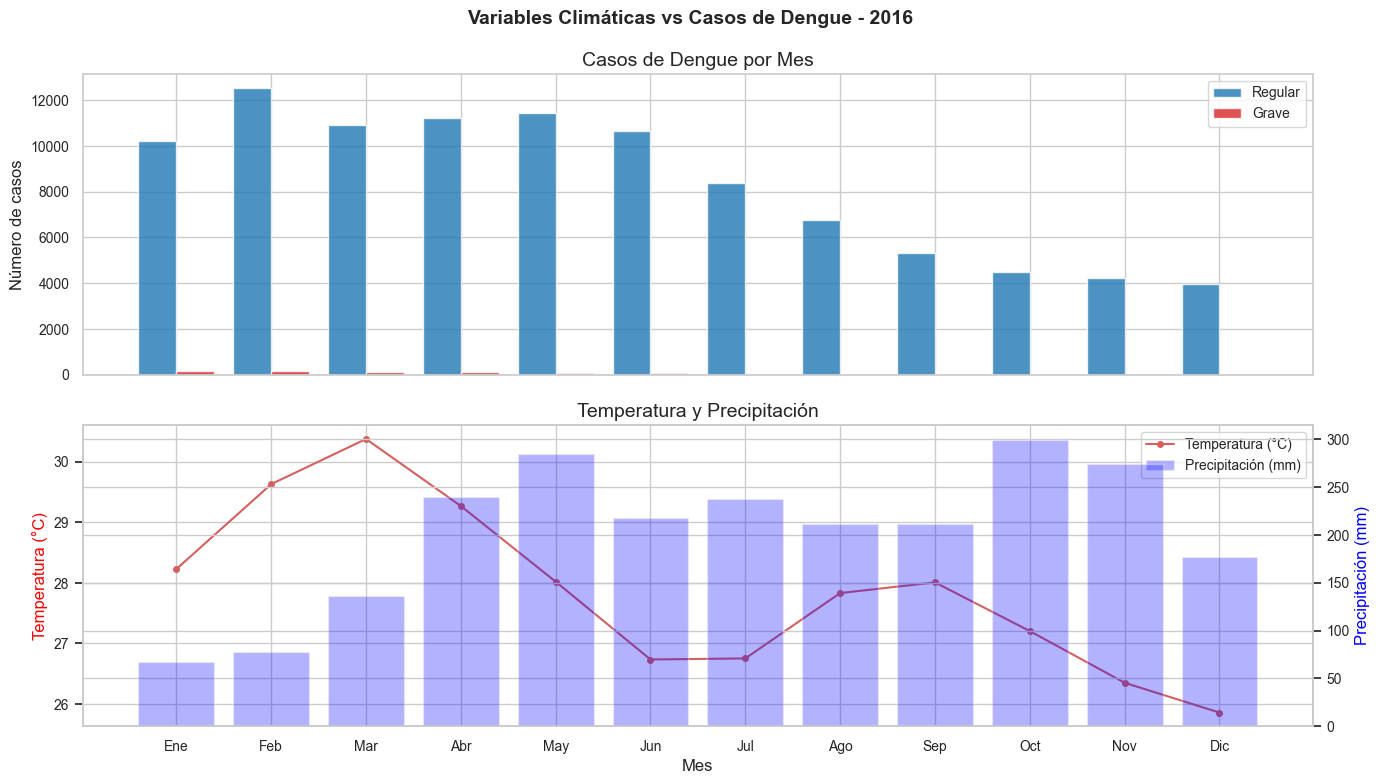

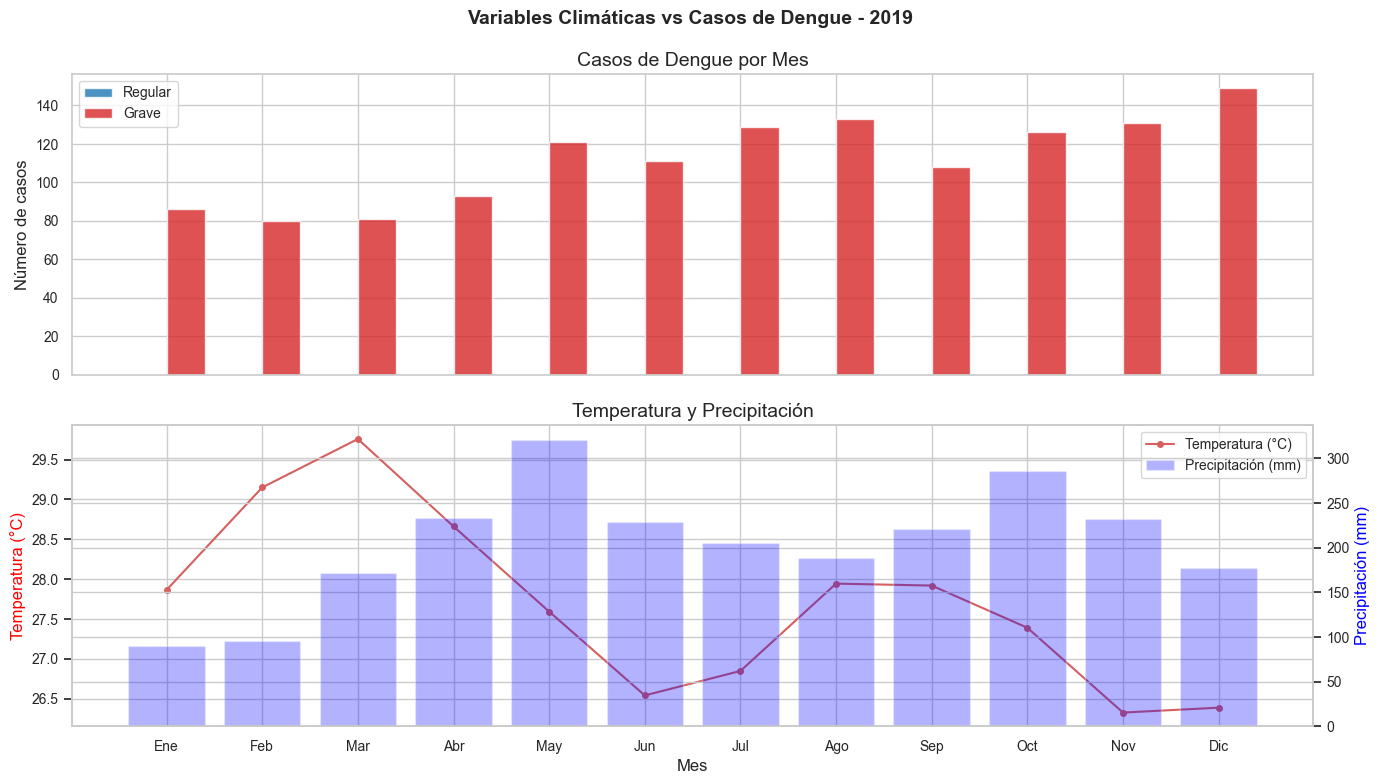

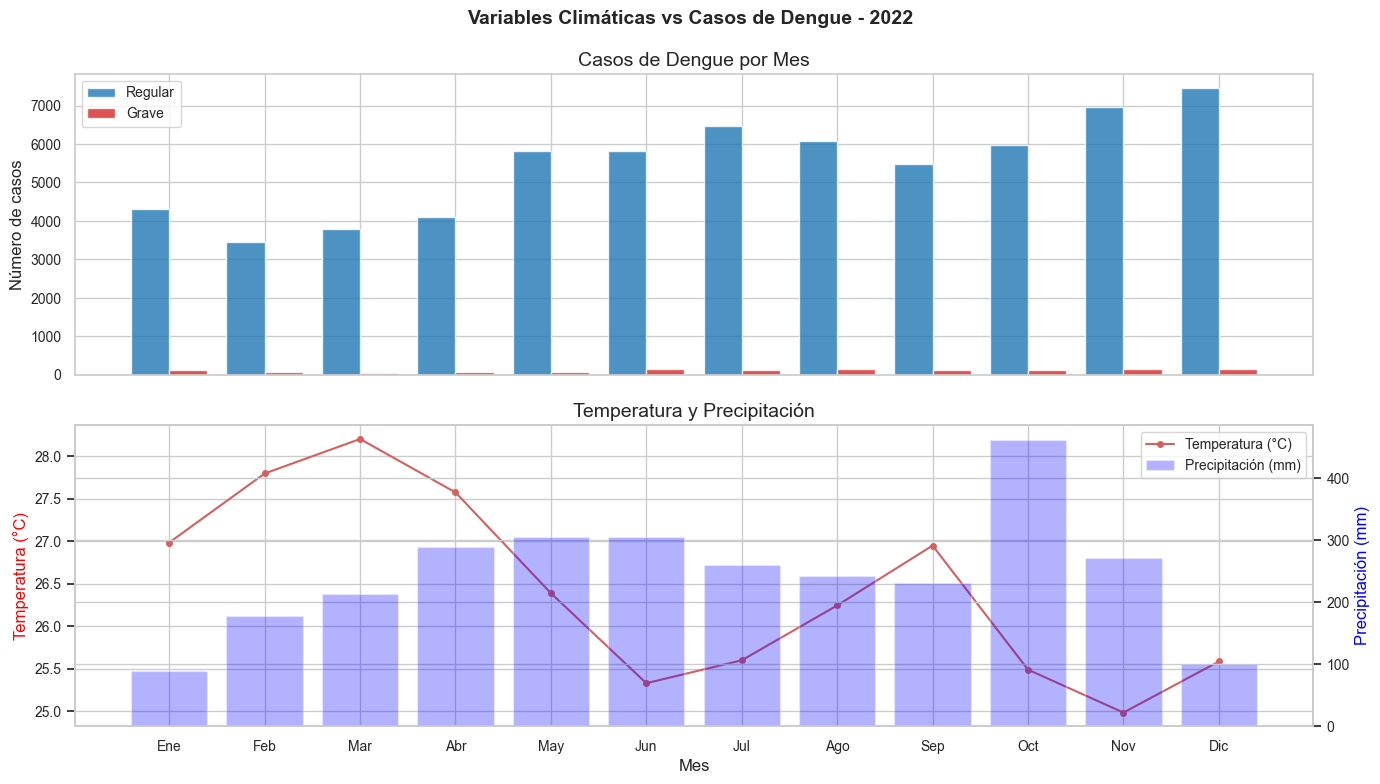

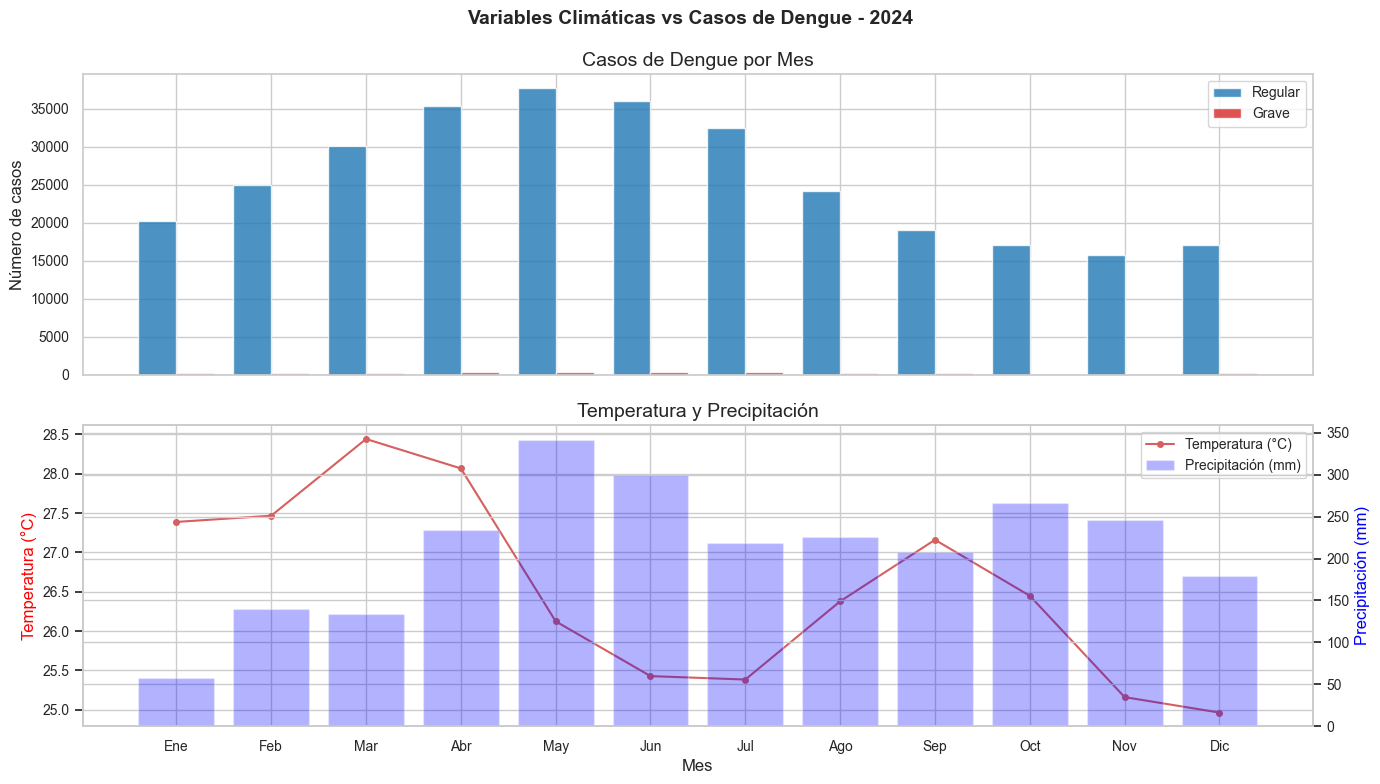

In [13]:
if df_clima is not None:
    # Promedios nacionales mensuales de variables climáticas vs casos
    clima_nacional = df_clima.groupby(['ano', 'mes']).agg({
        'temperatura_c': 'mean',
        'precipitacion_mm': 'mean',
        'ndvi': 'mean',
        'dewpoint_c': 'mean'
    }).reset_index()
    
    casos_nacional_reg = df_reg.groupby(['ANO', 'mes']).size().reset_index(name='casos_regular')
    casos_nacional_grav = df_grav.groupby(['ANO', 'mes']).size().reset_index(name='casos_grave')
    
    # Merge
    serie_nacional = clima_nacional.merge(
        casos_nacional_reg, left_on=['ano', 'mes'], right_on=['ANO', 'mes'], how='left'
    ).merge(
        casos_nacional_grav, left_on=['ano', 'mes'], right_on=['ANO', 'mes'], how='left'
    )
    serie_nacional['casos_regular'] = serie_nacional['casos_regular'].fillna(0)
    serie_nacional['casos_grave'] = serie_nacional['casos_grave'].fillna(0)
    
    # Gráficos de series de tiempo por año
    for ano in ANOS_ESTUDIO:
        datos = serie_nacional[serie_nacional['ano'] == ano]
        if len(datos) == 0:
            continue
        
        fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
        fig.suptitle(f'Variables Climáticas vs Casos de Dengue - {ano}',
                     fontsize=14, fontweight='bold')
        
        # Casos
        axes[0].bar(datos['mes'] - 0.2, datos['casos_regular'], 0.4,
                    label='Regular', color=PALETA_DENGUE['regular'], alpha=0.8)
        axes[0].bar(datos['mes'] + 0.2, datos['casos_grave'], 0.4,
                    label='Grave', color=PALETA_DENGUE['grave'], alpha=0.8)
        axes[0].set_ylabel('Número de casos')
        axes[0].legend()
        axes[0].set_title('Casos de Dengue por Mes')
        
        # Variables climáticas
        ax1 = axes[1]
        ax1.plot(datos['mes'], datos['temperatura_c'], 'r-o', label='Temperatura (°C)', markersize=4)
        ax1.set_ylabel('Temperatura (°C)', color='red')
        
        ax2 = ax1.twinx()
        ax2.bar(datos['mes'], datos['precipitacion_mm'], alpha=0.3, color='blue', label='Precipitación (mm)')
        ax2.set_ylabel('Precipitación (mm)', color='blue')
        
        ax1.set_xlabel('Mes')
        ax1.set_xticks(range(1, 13))
        ax1.set_xticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
                             'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
        ax1.set_title('Temperatura y Precipitación')
        
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
        
        plt.tight_layout()
        plt.show()
else:
    print('Sección omitida: datos climáticos no disponibles.')

## 6. Estacionalidad y Picos Epidémicos

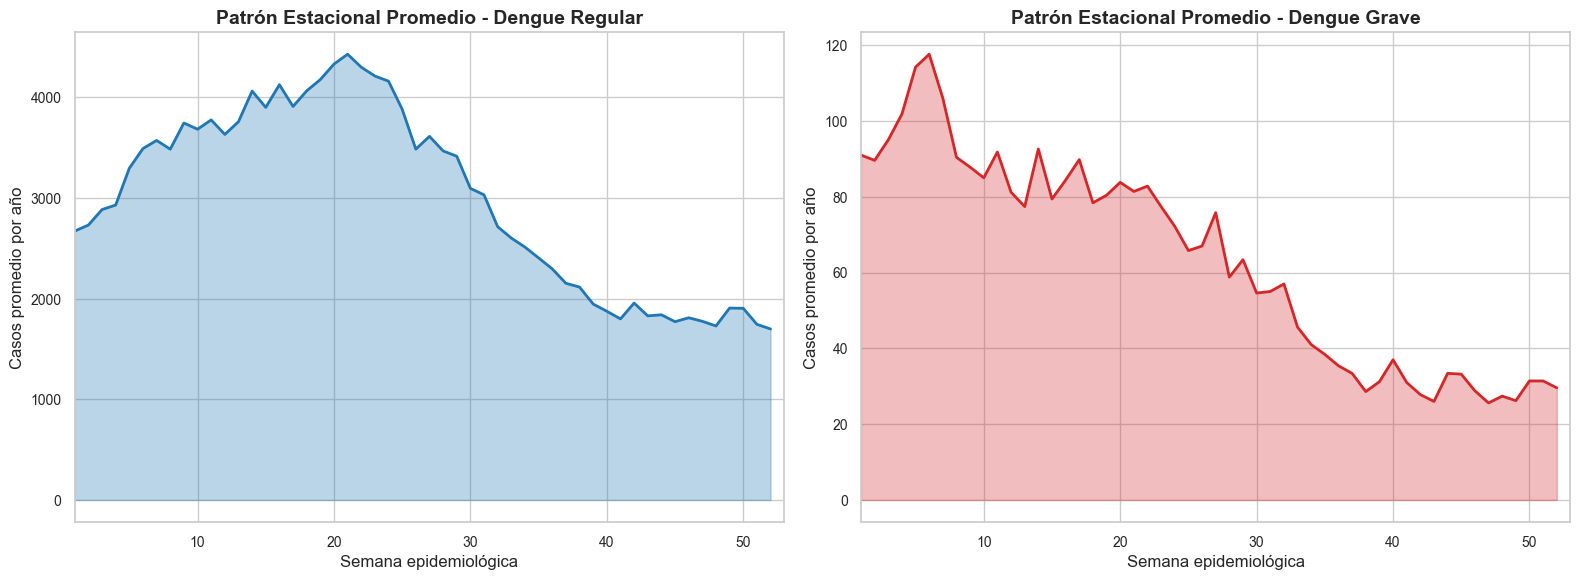

In [14]:
# Patrón estacional promedio por semana epidemiológica
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Regular - promedio por semana (todas los años)
sem_reg = df_reg.groupby('SEMANA').size()
sem_reg_prom = sem_reg / df_reg['ANO'].nunique()  # Promedio por año
axes[0].fill_between(sem_reg_prom.index, sem_reg_prom.values, alpha=0.3,
                      color=PALETA_DENGUE['regular'])
axes[0].plot(sem_reg_prom.index, sem_reg_prom.values, color=PALETA_DENGUE['regular'],
             linewidth=2)
axes[0].set_title('Patrón Estacional Promedio - Dengue Regular', fontweight='bold')
axes[0].set_xlabel('Semana epidemiológica')
axes[0].set_ylabel('Casos promedio por año')
axes[0].set_xlim(1, 53)

# Grave
sem_grav = df_grav.groupby('SEMANA').size()
sem_grav_prom = sem_grav / df_grav['ANO'].nunique()
axes[1].fill_between(sem_grav_prom.index, sem_grav_prom.values, alpha=0.3,
                      color=PALETA_DENGUE['grave'])
axes[1].plot(sem_grav_prom.index, sem_grav_prom.values, color=PALETA_DENGUE['grave'],
             linewidth=2)
axes[1].set_title('Patrón Estacional Promedio - Dengue Grave', fontweight='bold')
axes[1].set_xlabel('Semana epidemiológica')
axes[1].set_ylabel('Casos promedio por año')
axes[1].set_xlim(1, 53)

plt.tight_layout()
plt.show()

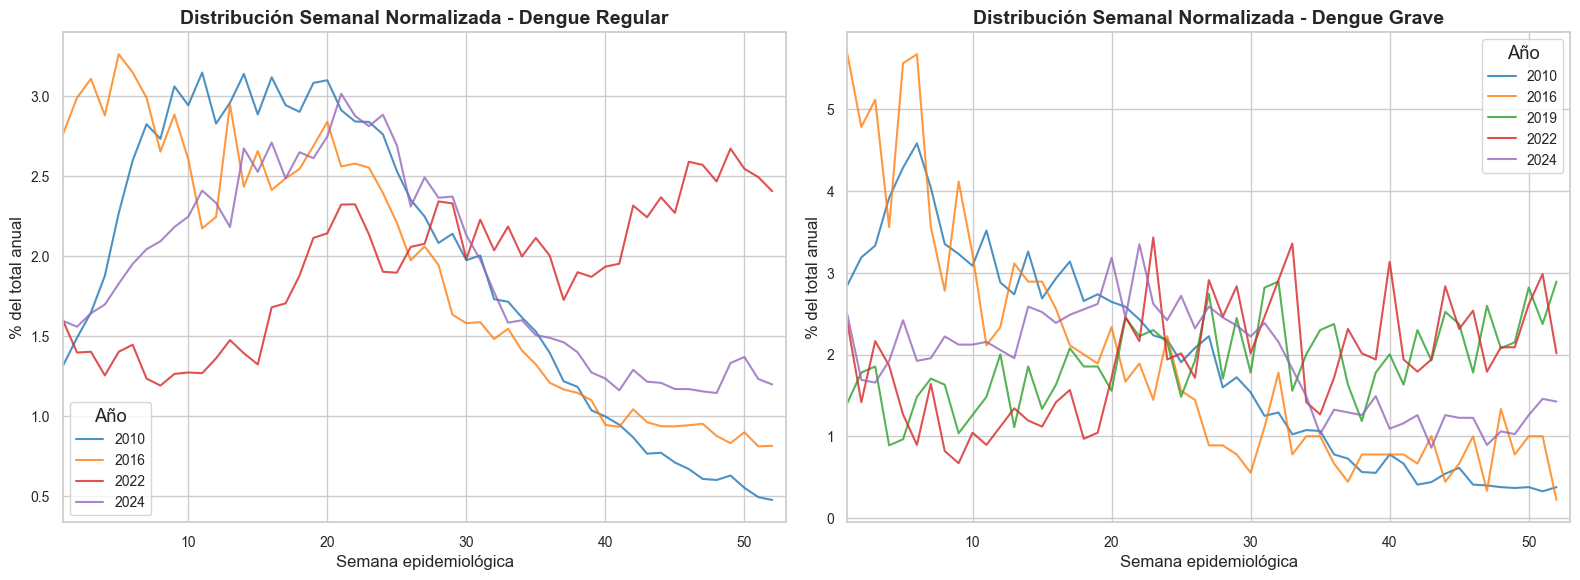

In [15]:
# Comparación de estacionalidad entre años (normalizado)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Regular
for ano in sorted(df_reg['ANO'].unique()):
    datos = df_reg[df_reg['ANO'] == ano]
    sem = datos['SEMANA'].value_counts().sort_index()
    # Normalizar: proporción del total del año
    sem_norm = sem / sem.sum() * 100
    axes[0].plot(sem_norm.index, sem_norm.values, label=str(ano),
                 color=COLORES_ANOS.get(ano, '#333'), linewidth=1.5, alpha=0.8)

axes[0].set_title('Distribución Semanal Normalizada - Dengue Regular', fontweight='bold')
axes[0].set_xlabel('Semana epidemiológica')
axes[0].set_ylabel('% del total anual')
axes[0].legend(title='Año')
axes[0].set_xlim(1, 53)

# Grave
for ano in sorted(df_grav['ANO'].unique()):
    datos = df_grav[df_grav['ANO'] == ano]
    sem = datos['SEMANA'].value_counts().sort_index()
    sem_norm = sem / sem.sum() * 100
    axes[1].plot(sem_norm.index, sem_norm.values, label=str(ano),
                 color=COLORES_ANOS.get(ano, '#333'), linewidth=1.5, alpha=0.8)

axes[1].set_title('Distribución Semanal Normalizada - Dengue Grave', fontweight='bold')
axes[1].set_xlabel('Semana epidemiológica')
axes[1].set_ylabel('% del total anual')
axes[1].legend(title='Año')
axes[1].set_xlim(1, 53)

plt.tight_layout()
plt.show()

## 7. Tasas de Incidencia Comparativas

In [17]:
# Tasa de incidencia nacional por año
pob_nacional = df_dane.groupby('departamento').first()  # Un registro por departamento para evitar doble conteo

pob_total = {}
for ano in [2010, 2016, 2019, 2020]:
    col = f'pob_{ano}'
    pob_total[ano] = df_dane[col].sum()

# Asignar población por año
tasa_nacional = []
for ano in ANOS_ESTUDIO:
    pob_ano = pob_total.get(ano, pob_total[2020])  # Usar 2020 si no hay dato exacto
    
    n_reg = len(df_reg[df_reg['ANO'] == ano])
    n_grav = len(df_grav[df_grav['ANO'] == ano])
    
    tasa_nacional.append({
        'ano': ano,
        'casos_regular': n_reg,
        'casos_grave': n_grav,
        'casos_total': n_reg + n_grav,
        'poblacion': pob_ano,
        'tasa_regular': n_reg / pob_ano * 100000 if n_reg > 0 else 0,
        'tasa_grave': n_grav / pob_ano * 100000,
        'tasa_total': (n_reg + n_grav) / pob_ano * 100000,
    })

df_tasa = pd.DataFrame(tasa_nacional)
print('Tasas de incidencia nacional por 100,000 habitantes:')
print(df_tasa[['ano', 'casos_total', 'tasa_regular', 'tasa_grave', 'tasa_total']].to_string(index=False))

Tasas de incidencia nacional por 100,000 habitantes:
 ano  casos_total  tasa_regular  tasa_grave  tasa_total
2010       156977    161.755446   10.715650  172.471096
2016       101016    102.689091    0.922096  103.611187
2019         1348      0.000000    1.337960    1.337960
2022        67031     64.513716    1.315985   65.829701
2024       312643    304.078008    2.961949  307.039957


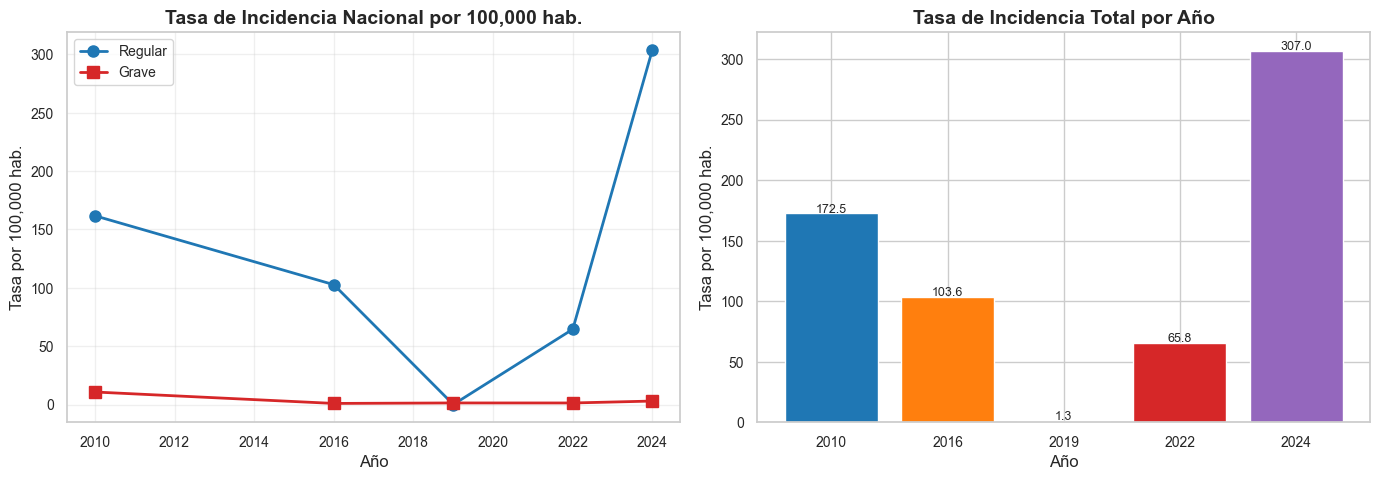

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Tasas de incidencia
axes[0].plot(df_tasa['ano'], df_tasa['tasa_regular'], 'o-', 
             color=PALETA_DENGUE['regular'], linewidth=2, markersize=8, label='Regular')
axes[0].plot(df_tasa['ano'], df_tasa['tasa_grave'], 's-',
             color=PALETA_DENGUE['grave'], linewidth=2, markersize=8, label='Grave')
axes[0].set_title('Tasa de Incidencia Nacional por 100,000 hab.', fontweight='bold')
axes[0].set_ylabel('Tasa por 100,000 hab.')
axes[0].set_xlabel('Año')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Tasa total
colores = [COLORES_ANOS.get(a, '#333') for a in df_tasa['ano']]
axes[1].bar(df_tasa['ano'].astype(str), df_tasa['tasa_total'], color=colores, edgecolor='white')
axes[1].set_title('Tasa de Incidencia Total por Año', fontweight='bold')
axes[1].set_ylabel('Tasa por 100,000 hab.')
axes[1].set_xlabel('Año')
for i, row in df_tasa.iterrows():
    axes[1].text(i, row['tasa_total'] + 1, f'{row["tasa_total"]:.1f}',
                 ha='center', fontsize=9)

plt.tight_layout()
plt.show()

## 8. Conclusiones y Hallazgos Principales

In [19]:
print('='*70)
print('  CONCLUSIONES Y HALLAZGOS PRINCIPALES')
print('='*70)

print(f'''
1. MAGNITUD DEL PROBLEMA
   - Se analizaron {len(df_reg):,} casos de dengue regular y {len(df_grav):,} de dengue grave.
   - Los años con mayor número de casos fueron identificados en el análisis temporal.

2. DISTRIBUCIÓN TEMPORAL
   - Se observa un patrón estacional claro con picos en las primeras semanas
     del año, coincidiendo con la temporada de lluvias.
   - La dinámica temporal de dengue regular y grave muestran patrones similares.

3. DISTRIBUCIÓN GEOGRÁFICA
   - Los departamentos más afectados se concentran en zonas de clima cálido
     y húmedo, favorables para la reproducción del vector Aedes aegypti.
   - La mayoría de los casos ocurren en cabeceras municipales (zonas urbanas).

4. PERFIL DEMOGRÁFICO
   - El dengue afecta a todos los grupos etarios, con mayor incidencia en
     población joven y adulta.
   - La distribución por sexo es relativamente equilibrada.

5. SEVERIDAD
   - La proporción de dengue grave respecto al total varía entre los años
     analizados.
   - La tasa de letalidad del dengue grave varía por año y grupo etario.
   - Los extremos de edad (menores de 5 y mayores de 60) tienden a presentar
     mayor letalidad.

6. VARIABLES CLIMÁTICAS (si disponibles)
   - Se espera una correlación positiva entre temperatura/precipitación y
     casos de dengue, dado el ciclo biológico del vector.
   - El NDVI (vegetación) puede servir como proxy de condiciones ambientales
     favorables para el mosquito.

7. LIMITACIONES
   - No se dispone de datos de dengue regular para 2019.
   - Las proyecciones DANE solo llegan hasta 2020; para 2022 y 2024 se usó
     la proyección de 2020 como aproximación.
   - El subregistro es un problema conocido en los sistemas de vigilancia.
''')

# Tabla resumen final
print('\nTABLA RESUMEN:')
print(df_tasa[['ano', 'casos_regular', 'casos_grave', 'casos_total',
               'tasa_total']].rename(columns={
    'ano': 'Año',
    'casos_regular': 'Dengue Regular',
    'casos_grave': 'Dengue Grave',
    'casos_total': 'Total',
    'tasa_total': 'Tasa x 100K hab'
}).to_string(index=False))

  CONCLUSIONES Y HALLAZGOS PRINCIPALES

1. MAGNITUD DEL PROBLEMA
   - Se analizaron 622,659 casos de dengue regular y 16,356 de dengue grave.
   - Los años con mayor número de casos fueron identificados en el análisis temporal.

2. DISTRIBUCIÓN TEMPORAL
   - Se observa un patrón estacional claro con picos en las primeras semanas
     del año, coincidiendo con la temporada de lluvias.
   - La dinámica temporal de dengue regular y grave muestran patrones similares.

3. DISTRIBUCIÓN GEOGRÁFICA
   - Los departamentos más afectados se concentran en zonas de clima cálido
     y húmedo, favorables para la reproducción del vector Aedes aegypti.
   - La mayoría de los casos ocurren en cabeceras municipales (zonas urbanas).

4. PERFIL DEMOGRÁFICO
   - El dengue afecta a todos los grupos etarios, con mayor incidencia en
     población joven y adulta.
   - La distribución por sexo es relativamente equilibrada.

5. SEVERIDAD
   - La proporción de dengue grave respecto al total varía entre los años
